<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Hands on Lab: Complete the Machine Learning Prediction lab


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [1]:
import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])

We will import the following libraries for the lab


In [2]:
# Import required libraries
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
# Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standardize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split, GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
# Import metrics for evaluation
from sklearn.metrics import confusion_matrix, classification_report

<ipython-input-2-8b120471fcab>:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


This function is to plot the confusion matrix.


In [3]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evaluates a classification model using a confusion matrix and classification report.
    """
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print Classification Report
    print(f"Classification Report - {model_name}")
    print(classification_report(y_true, y_pred, target_names=['Not Landed', 'Landed']))


## Load the dataframe


Load the data


In [4]:
from js import fetch
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = await fetch(URL1)
text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(text1)

In [5]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [6]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = await fetch(URL2)
text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(text2)

In [7]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## Defining the Evaluate Function

In [8]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evaluate a classification model: plot confusion matrix and print classification report.
    """
    from sklearn.metrics import confusion_matrix, classification_report

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

    # Print classification report
    print(f"\nClassification Report - {model_name}")
    print(classification_report(y_true, y_pred, target_names=['Not Landed', 'Landed']))


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [9]:
Y = data['Class'].to_numpy()

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [10]:
# students get this 
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

we can see we only have 18 test samples.


In [12]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [13]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [14]:
parameters = {'C': [0.01, 0.1, 1], 'penalty': ['l2'], 'solver': ['lbfgs']}

# Create Logistic Regression object
lr = LogisticRegression()

# Apply GridSearchCV
logreg_cv = GridSearchCV(lr, parameters, cv=10)

# Fit model on training data
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [15]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [16]:
# Logistic Regression Test Accuracy
logreg_test_accuracy = logreg_cv.score(X_test, Y_test)
print(f"Logistic Regression Test Accuracy: {logreg_test_accuracy:.4f}")

Logistic Regression Test Accuracy: 0.8333


Lets look at the confusion matrix:


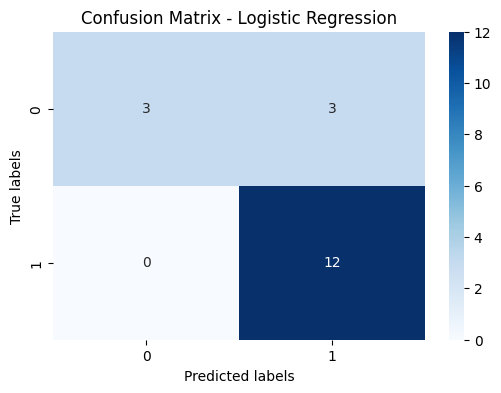


Classification Report - Logistic Regression
              precision    recall  f1-score   support

  Not Landed       1.00      0.50      0.67         6
      Landed       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



In [17]:
# Predict the test set
yhat_logreg = logreg_cv.predict(X_test)

# Evaluate the model
evaluate_model(Y_test, yhat_logreg, "Logistic Regression")

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the problem is false positives.

Overview:

True Postive - 12 (True label is landed, Predicted label is also landed)

False Postive - 3 (True label is not landed, Predicted label is landed)


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [18]:
# Define hyperparameters grid
parameters = {
    'kernel': ('linear', 'rbf', 'poly', 'sigmoid'),
    'C': np.logspace(-3, 3, 5),
    'gamma': np.logspace(-3, 3, 5)
}

# Create Support Vector Machine model
svm = SVC()

In [19]:
# Create GridSearchCV object with 10-fold cross validation
svm_cv = GridSearchCV(svm, parameters, cv=10)

# Fit to training data
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')})

In [20]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [21]:
# Calculate SVM accuracy on the test data
svm_test_accuracy = svm_cv.score(X_test, Y_test)

print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")


SVM Test Accuracy: 0.8333


We can plot the confusion matrix


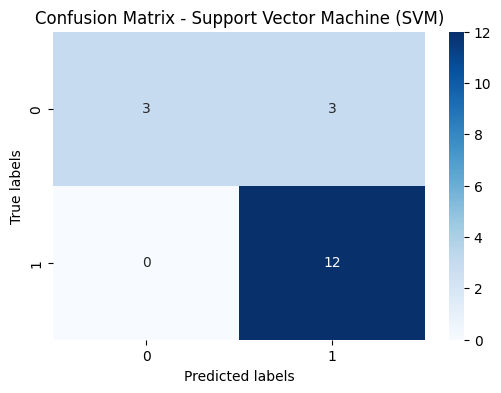


Classification Report - Support Vector Machine (SVM)
              precision    recall  f1-score   support

  Not Landed       1.00      0.50      0.67         6
      Landed       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



In [22]:
# Predict the test set
yhat_svm = svm_cv.predict(X_test)

# Evaluate the model
evaluate_model(Y_test, yhat_svm, model_name="Support Vector Machine (SVM)")


## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [23]:
# Define parameter grid
parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2*n for n in range(1,10)],
    'max_features': ['sqrt'],  # 'auto' causes error; using 'sqrt'
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Create Decision Tree Classifier object
tree = DecisionTreeClassifier()

In [24]:
# Create GridSearchCV object
tree_cv = GridSearchCV(tree, parameters, cv=10)

# Fit on training data
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [25]:
# Print best parameters and accuracy
print("tuned hyperparameters: (best parameters)", tree_cv.best_params_)
print("accuracy:", tree_cv.best_score_)

tuned hyperparameters: (best parameters) {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}
accuracy: 0.875


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [26]:
# TASK 9: Evaluate Decision Tree Classifier on Test Data
tree_test_accuracy = tree_cv.score(X_test, Y_test)
print(f"Decision Tree Test Accuracy: {tree_test_accuracy:.4f}")


Decision Tree Test Accuracy: 0.8333


We can plot the confusion matrix


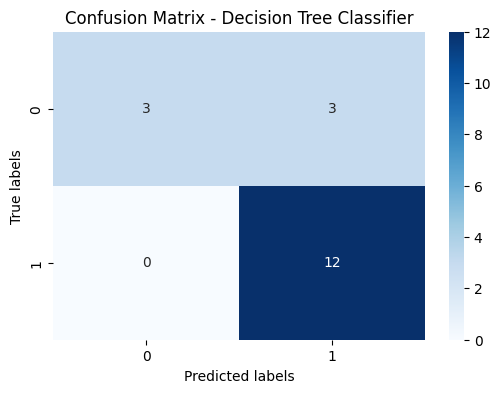


Classification Report - Decision Tree Classifier
              precision    recall  f1-score   support

  Not Landed       1.00      0.50      0.67         6
      Landed       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



In [35]:
# Predict the test set
yhat_tree = tree_cv.predict(X_test)

# Use evaluate_model (confusion matrix and classification report)
evaluate_model(Y_test, yhat_tree, "Decision Tree Classifier")

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [28]:
# Define parameter grid
parameters = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # p=1 (Manhattan), p=2 (Euclidean)
}

# Create KNN classifier object
KNN = KNeighborsClassifier()

In [29]:
# Perform GridSearchCV
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [30]:
# Output best parameters and best validation score
print("Tuned hyperparameters :(best parameters)", knn_cv.best_params_)
print("Validation accuracy:", knn_cv.best_score_)

Tuned hyperparameters :(best parameters) {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
Validation accuracy: 0.8482142857142858


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [31]:
# Calculate the KNN test accuracy
knn_accuracy = knn_cv.score(X_test, Y_test)
print(f"KNN Test Accuracy: {knn_accuracy:.4f}")

KNN Test Accuracy: 0.8333


We can plot the confusion matrix


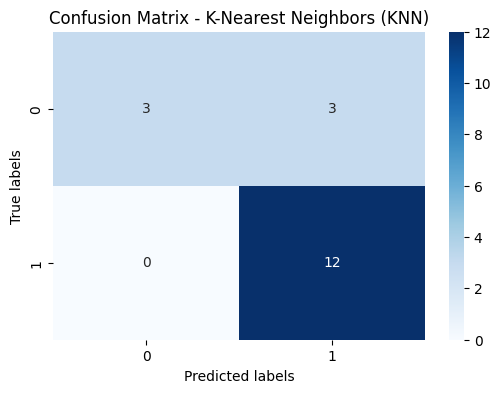


Classification Report - K-Nearest Neighbors (KNN)
              precision    recall  f1-score   support

  Not Landed       1.00      0.50      0.67         6
      Landed       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



In [32]:
# Predict the test set
yhat_knn = knn_cv.predict(X_test)

# Use evaluate_model (confusion matrix and classification report)
evaluate_model(Y_test, yhat_knn, "K-Nearest Neighbors (KNN)")

## TASK  12


Find the method performs best:


**Observations:**

- All four models achieved the same test accuracy of 83.33% on the test set.
- However, when considering cross-validation scores (via GridSearchCV.best_score_), the Decision Tree Classifier demonstrated the highest cross-validation accuracy (~87.5%)
- Confusion matrices and classification reports across all models show consistent patterns:
  - Excellent performance in predicting the "Landed" class (recall = 1.0).
  - Moderate performance in predicting the "Not Landed" class (recall = 0.5).

<ipython-input-38-4411cc92b9fb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


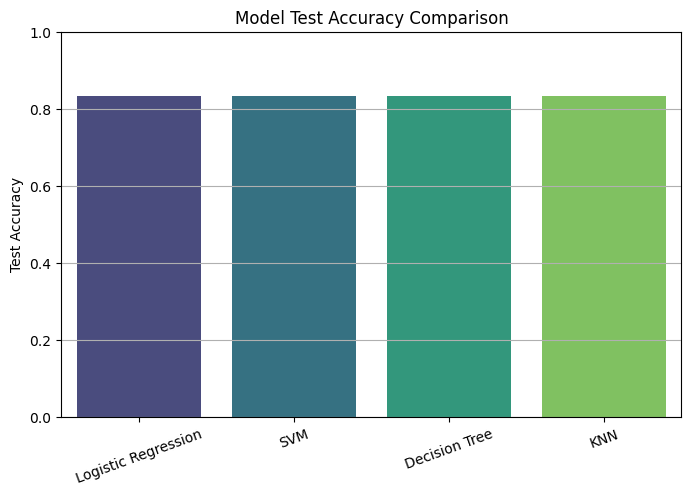

In [38]:
# Bar Chart: Accuracy Comparison

# Data
models = ['Logistic Regression', 'SVM', 'Decision Tree', 'KNN']
accuracies = [0.8333, 0.8333, 0.8333, 0.8333]

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.ylim(0, 1)
plt.ylabel('Test Accuracy')
plt.title('Model Test Accuracy Comparison')
plt.grid(axis='y')
plt.xticks(rotation=20)
plt.show()


<ipython-input-40-553bdd47f6e1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=precision_landed, palette='coolwarm')


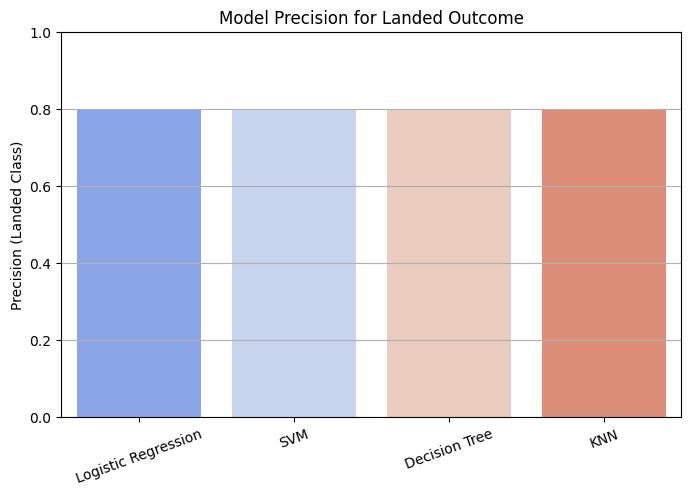

In [40]:
# Bar Chart: Precision (Landed Class)

# Data
precision_landed = [0.80, 0.80, 0.80, 0.80]

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=precision_landed, palette='coolwarm')
plt.ylim(0, 1)
plt.ylabel('Precision (Landed Class)')
plt.title('Model Precision for Landed Outcome')
plt.grid(axis='y')
plt.xticks(rotation=20)
plt.show()


<ipython-input-41-d4dfc9d44398>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=recall_landed, palette='magma')


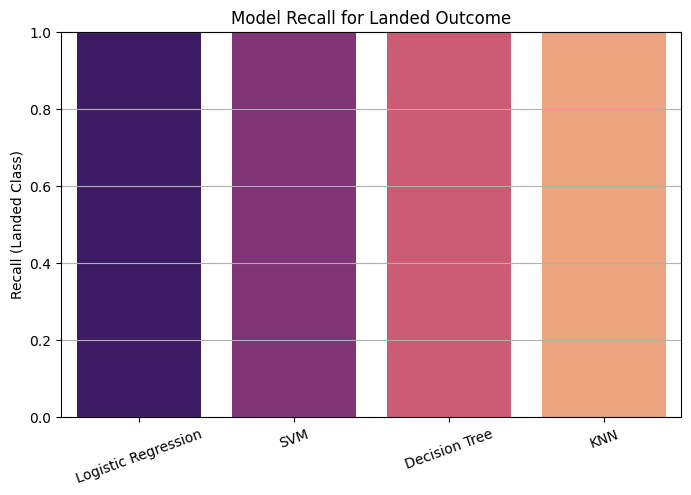

In [41]:
# Bar Chart: Recall (Landed Class)

# Data
recall_landed = [1.00, 1.00, 1.00, 1.00]

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=recall_landed, palette='magma')
plt.ylim(0, 1)
plt.ylabel('Recall (Landed Class)')
plt.title('Model Recall for Landed Outcome')
plt.grid(axis='y')
plt.xticks(rotation=20)
plt.show()


<ipython-input-42-35a3b42b3f09>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=f1_landed, palette='cubehelix')


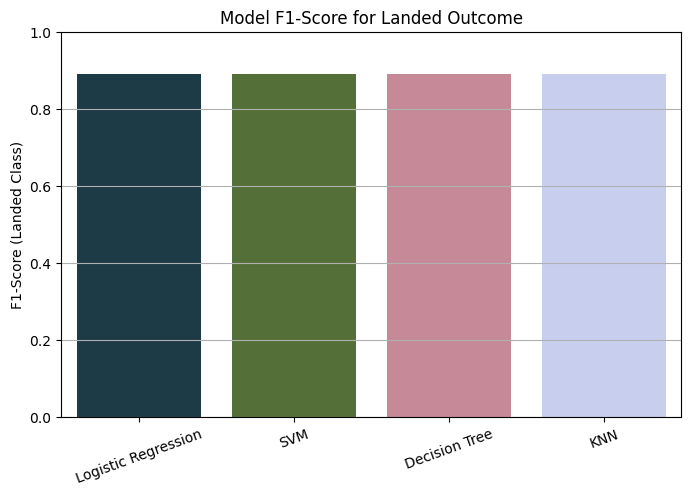

In [42]:
# Bar Chart: F1-Score (Landed Class)

# Data
f1_landed = [0.89, 0.89, 0.89, 0.89]

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=f1_landed, palette='cubehelix')
plt.ylim(0, 1)
plt.ylabel('F1-Score (Landed Class)')
plt.title('Model F1-Score for Landed Outcome')
plt.grid(axis='y')
plt.xticks(rotation=20)
plt.show()


In [43]:
# Comparing corss validation accuracy for each model

print("Cross-validation Accuracy for Logistic Regression:", logreg_cv.best_score_)
print("Cross-validation Accuracy for SVM:", svm_cv.best_score_)
print("Cross-validation Accuracy for Decision Tree:", tree_cv.best_score_)
print("Cross-validation Accuracy for KNN:", knn_cv.best_score_)


Cross-validation Accuracy for Logistic Regression: 0.8464285714285713
Cross-validation Accuracy for SVM: 0.8482142857142856
Cross-validation Accuracy for Decision Tree: 0.875
Cross-validation Accuracy for KNN: 0.8482142857142858


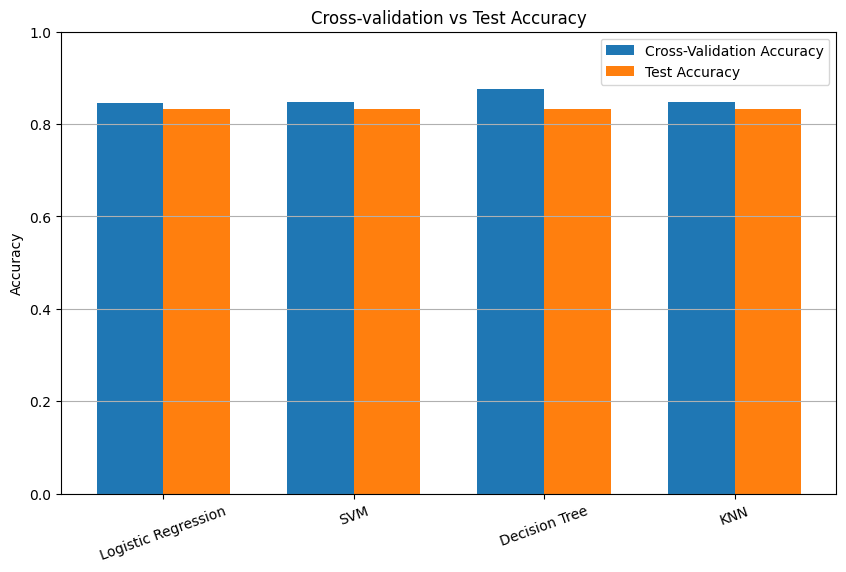

In [45]:
# Data
cross_val_scores = [0.8464, 0.8482, 0.875, 0.8482]
test_scores = [0.8333, 0.8333, 0.8333, 0.8333]

x = np.arange(len(models))
width = 0.35

# Plot
plt.figure(figsize=(10,6))
plt.bar(x - width/2, cross_val_scores, width, label='Cross-Validation Accuracy')
plt.bar(x + width/2, test_scores, width, label='Test Accuracy')

plt.ylabel('Accuracy')
plt.title('Cross-validation vs Test Accuracy')
plt.xticks(x, models, rotation=20)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')
plt.show()


**Final Reccomendations**

While all models achieved similar test set performance (83.33%), the Decision Tree Classifier demonstrated the highest cross-validation accuracy (~87.5%). Based on its stronger validation results and consistent test accuracy, the Decision Tree Classifier is selected as the optimal model for predicting Falcon 9 first stage landing outcomes.

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/)


<!--## Change Log--!>


<!--| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|--!>


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
